In [1]:
import sys
import os

# Source: https://stackoverflow.com/questions/16780014/import-file-from-parent-directory
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__name__))))

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import altair as alt

from sklearn.datasets import make_circles, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from lui.svm import SVMRandomInvariants
from lui.ecoc import SVMRandomInvariantsECOC
from lui.types import InvariantTypes

In [2]:
# Generate datasets
datasets = [
    make_circles(1000, noise=0.1, factor=0.5, random_state=47),
    make_moons(1000, noise=0.05, random_state=47),
]

In [3]:
def plot_datasets(datasets, titles):
    figure = plt.figure(figsize=(12,5))
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    for i in range(len(datasets)):
        X, y = datasets[i]
        plt.subplot(1, 2, i+1)
        plt.title(titles[i])
        plt.scatter(X[:,0], X[:,1], c=y, cmap=cm_bright, edgecolors='k')
    
    plt.savefig("toy_datasets.png")
    plt.show()

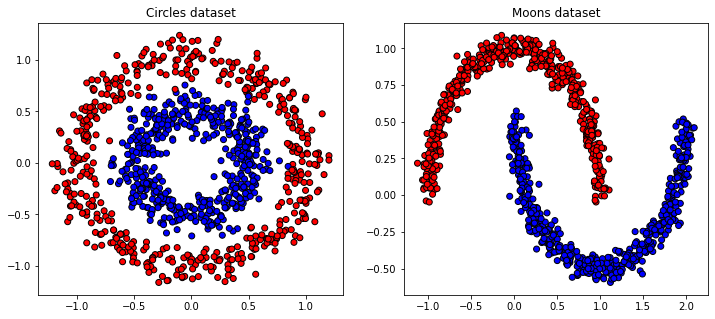

In [4]:
plot_datasets(datasets, ['Circles dataset', 'Moons dataset'])

## Testing hyperparameters

In [5]:
def plot_decision_boundary(clf, X, y, ax, level=0.5, min_val=0.0, max_val=1.0, title=''):
    h = .02
    x_min, x_max = X[:, 0].min() - .2, X[:, 0].max() + .2
    y_min, y_max = X[:, 1].min() - .2, X[:, 1].max() + .2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    viz=np.c_[xx.ravel(),yy.ravel()]
    Z = clf.predict_proba(viz)
    Z = Z.reshape(xx.shape)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax.set_title(title)
    contour_surface = ax.contourf(xx, yy, Z, levels=np.linspace(min_val, max_val, 11), cmap=cm, alpha=.8)
    ax.contour(xx, yy, Z, levels=[level], linestyles='dashed')
    ax.scatter(X[:,0], X[:,1], c=y, cmap=cm_bright, edgecolors='k')
    plt.tight_layout()

X, y = datasets[0]

In [6]:
def run_experiment_dataset(dataset, seeds, invariant_types, out_file):
    num_invariants = {
        invariant: [] for invariant in invariant_types
    }
    
    X, y = dataset
    
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        train_size=0.1,
        stratify=y,
        random_state=47,
    )
    
    for seed in seeds:
        for invariant_type in invariant_types:
            clf = SVMRandomInvariants(num_invariants=3, invariant_type=invariant_type)
            clf.fit(X_train, y_train)
            num_invariants[invariant_type].append(len(clf.invariants))
    
    mean_invariants = {invariant: np.mean(n_invariants) for invariant, n_invariants in num_invariants.items()}
    
    fig, ax = plt.subplots(len(invariant_types), 2, figsize=(10, 15))

    invariant_names = {
        InvariantTypes.VAPNIK: "Vapnik invariants",
        InvariantTypes.PROJECTION: "random projections",
        InvariantTypes.HYPERPLANE: "random hyperplanes"
    }

    for i, invariant_type in enumerate(invariant_types):
        clf = SVMRandomInvariants(num_invariants=3, invariant_type=invariant_type, random_state=4)
        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print("Accuracy: ", acc)

        plot_decision_boundary(clf, X_train, y_train, ax[i, 0], title=f'Decision boundary with training data\nusing {invariant_names[invariant_type]}')
        plot_decision_boundary(clf, X_test, y_test, ax[i, 1], title=f'Decision boundary with test data\nusing {invariant_names[invariant_type]}')
    
    plt.savefig(out_file)
    plt.show()

    
    return mean_invariants


def run_ecoc_experiment_dataset(dataset, seeds, invariant_types, out_file):    
    X, y = dataset
    
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        train_size=0.1,
        stratify=y,
        random_state=47,
    )

    fig, ax = plt.subplots(len(invariant_types), 2, figsize=(10, 15))

    invariant_names = {
        InvariantTypes.VAPNIK: "Vapnik invariants",
        InvariantTypes.PROJECTION: "random projections",
        InvariantTypes.HYPERPLANE: "random hyperplanes"
    }
    
    encoding = np.eye(2)

    for i, invariant_type in enumerate(invariant_types):
        clf = SVMRandomInvariantsECOC(encoding, num_invariants=3, invariant_type=invariant_type, random_state=4)
        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print("Accuracy: ", acc)

        plot_decision_boundary(clf, X_train, y_train, ax[i, 0], level=1.0, max_val=2.0, title=f'Decision boundary with training data\nusing {invariant_names[invariant_type]}')
        plot_decision_boundary(clf, X_test, y_test, ax[i, 1], level=1.0, max_val=2.0, title=f'Decision boundary with test data\nusing {invariant_names[invariant_type]}')
    
    plt.savefig(out_file)
    plt.show()

        

Accuracy:  0.9922222222222222
Accuracy:  0.9922222222222222
Accuracy:  0.9911111111111112


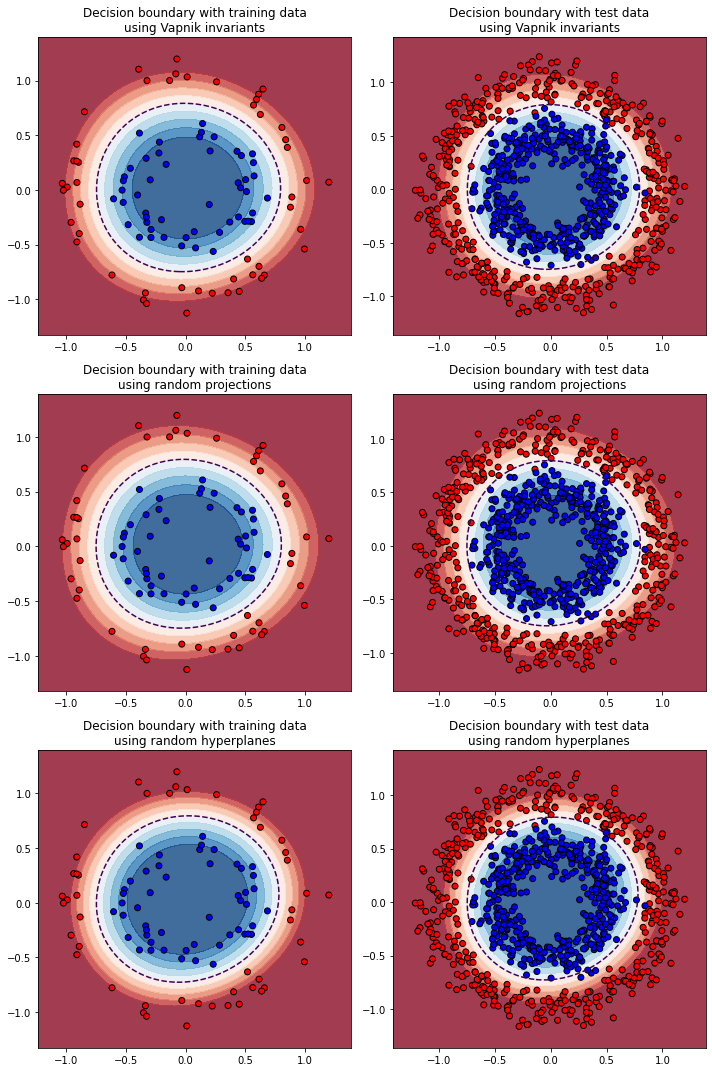

Accuracy:  0.9588888888888889
Accuracy:  0.96
Accuracy:  0.9844444444444445


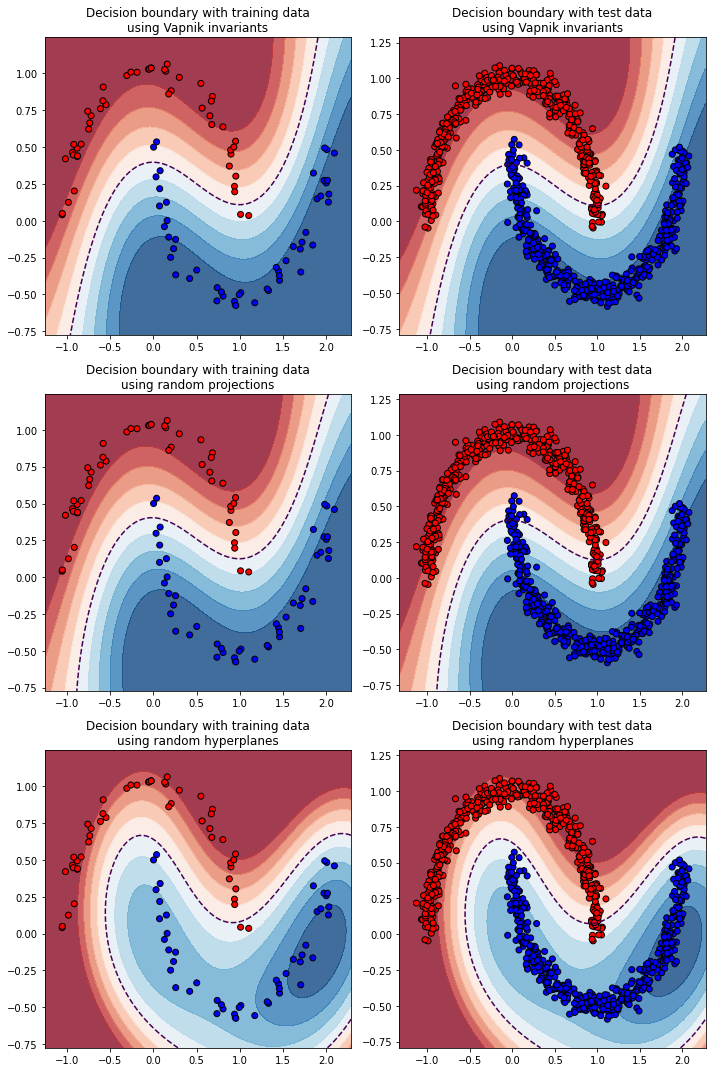

Accuracy:  0.9922222222222222
Accuracy:  0.9922222222222222
Accuracy:  0.9855555555555555


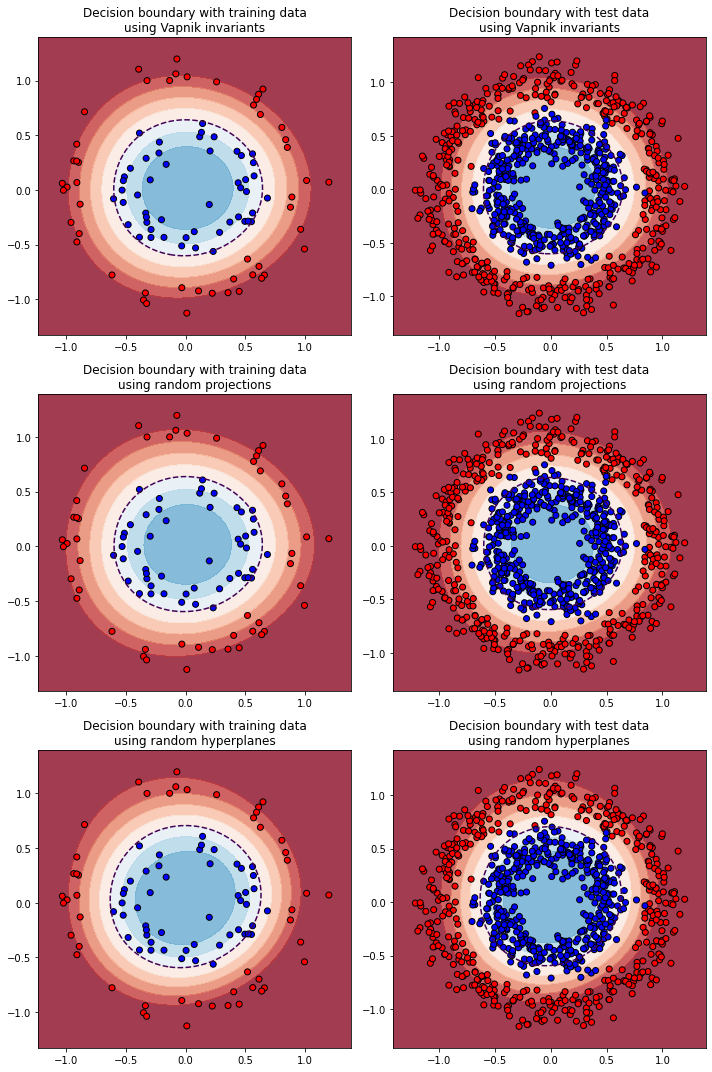

Accuracy:  0.9622222222222222
Accuracy:  0.96
Accuracy:  0.9488888888888889


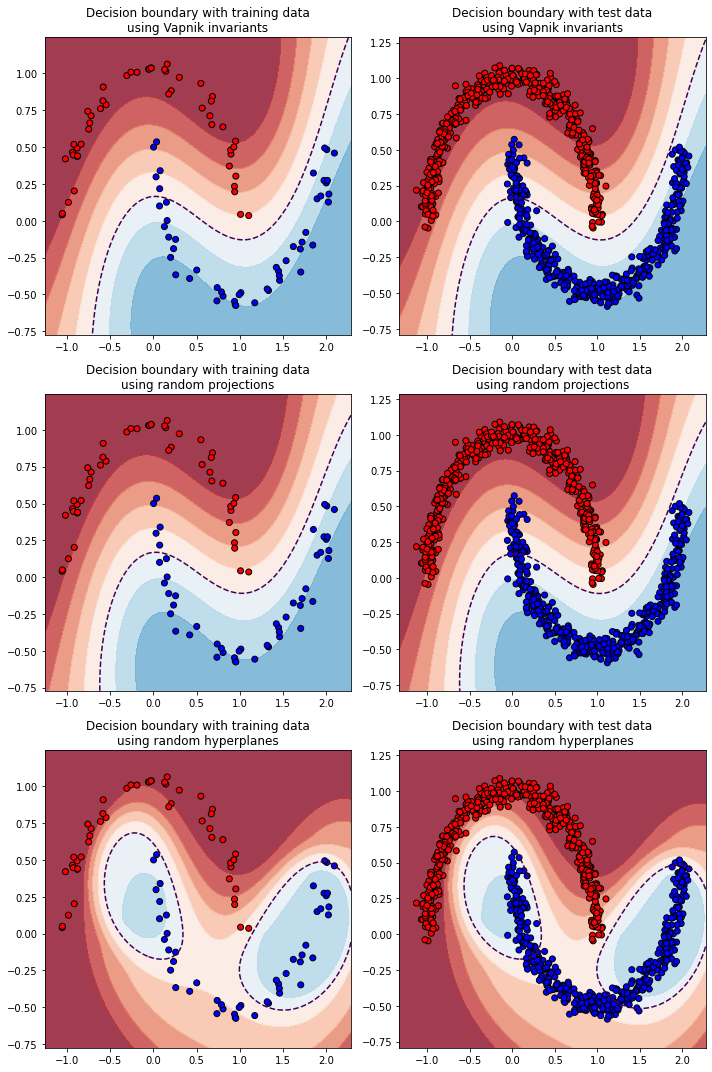

In [7]:
seeds = [42, 47, 194, 8923, 293, 7892, 9123, 923184, 83291, 193927]
invariant_types = [InvariantTypes.VAPNIK, InvariantTypes.PROJECTION, InvariantTypes.HYPERPLANE]

n_invariants_circles = run_experiment_dataset(datasets[0], seeds, invariant_types, 'circles_decision_boundaries.png')
n_invariants_moons = run_experiment_dataset(datasets[1], seeds, invariant_types, 'moons_decision_boundaries.png')

run_ecoc_experiment_dataset(datasets[0], seeds, invariant_types, 'circles_decision_boundaries_ecoc.png')
run_ecoc_experiment_dataset(datasets[1], seeds, invariant_types, 'moons_decision_boundaries_ecoc.png')

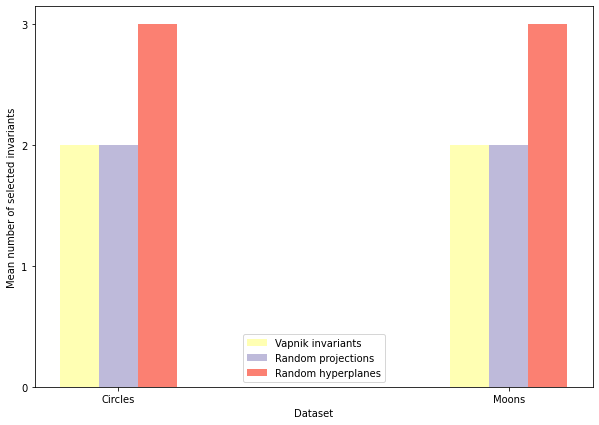

In [8]:
vapnik_results = [n_invariants_circles[InvariantTypes.VAPNIK], n_invariants_moons[InvariantTypes.VAPNIK]]
proj_results = [n_invariants_circles[InvariantTypes.PROJECTION], n_invariants_moons[InvariantTypes.PROJECTION]]
hyp_results = [n_invariants_circles[InvariantTypes.HYPERPLANE], n_invariants_moons[InvariantTypes.HYPERPLANE]]

width = 0.1

X = ["Circles", "Moons"]
X_axis = np.arange(len(X))
plt.figure(figsize=(10, 7))
plt.bar(X_axis - width, vapnik_results, width=width, label="Vapnik invariants", color="#ffffb3")
plt.bar(X_axis, proj_results, width=width, label="Random projections", color="#bebada")
plt.bar(X_axis + width, hyp_results, width=width, label="Random hyperplanes", color="#fb8072")
  
plt.xticks(X_axis, X)
plt.yticks(np.arange(0, 4))

plt.xlabel('Dataset')
plt.ylabel('Mean number of selected invariants')
plt.legend()


plt.savefig("num_selected_invariants.png")
plt.show()

In [9]:
from collections import Counter

def run_large_experiment(dataset, seeds, invariant_types, title=''):
    X, y = dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        train_size=0.1,
        stratify=y,
        random_state=47,
    )
    
    n_selected = {
        InvariantTypes.PROJECTION: [],
        InvariantTypes.HYPERPLANE: [],
        InvariantTypes.VAPNIK: [],
    }

    first_selected = {
        InvariantTypes.PROJECTION: [],
        InvariantTypes.HYPERPLANE: [],
        InvariantTypes.VAPNIK: [],
    }
    
    max_selected = {
        InvariantTypes.PROJECTION: [],
        InvariantTypes.HYPERPLANE: [],
        InvariantTypes.VAPNIK: [],
    }
    
    accuracies = []

    for seed in seeds:
        clf = SVMRandomInvariants(num_invariants=50, invariant_type=InvariantTypes.ALL, random_state=seed)
        clf.fit(X_train, y_train)
        invariants = clf.invariants
        
        y_pred = clf.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
        
        selected_counts = Counter(invariant['type'] for invariant in invariants)
        
        first_invariants = invariants[:10]
        first_counts = Counter(invariant['type'] for invariant in first_invariants)
        
        max_first = sorted(invariants, key=lambda x: -x['T_value'])[:10]
        max_counts = Counter(invariant['type'] for invariant in max_first)
        
        for type_key in n_selected.keys():
            n_selected[type_key].append(selected_counts[type_key] if type_key in selected_counts.keys() else 0)
            first_selected[type_key].append(first_counts[type_key] if type_key in first_counts.keys() else 0)
            max_selected[type_key].append(max_counts[type_key] if type_key in max_counts.keys() else 0)

    print(f"\n\n------------ {title} ------------\n\n")
    print("\n----- Accuracy information ------")
    print("\n\nAccuracies: ", accuracies)
    print("Mean accuracy: ", np.mean(accuracies))
    print("Min accuracy: ", np.min(accuracies))
    print("Max accuracy: ", np.max(accuracies))
    print("Std: ", np.std(accuracies))

    print("\n----- Invariants information ------")

    for type_key in n_selected.keys():
        print("\n\nInformation for invariant type ", type_key)
        print("Number of times selected: ", n_selected[type_key])
        print("Mean number of times selected: ", np.mean(n_selected[type_key]))
        print("Number of times selected among the first 10: ", first_selected[type_key])
        print("Mean number of times selected among the first 10: ", np.round(np.mean(first_selected[type_key])))
        print("Number of times selected with the maximum values: ", max_selected[type_key])
        print("Mean number of times selected with the maximum values: ", np.round(np.mean(max_selected[type_key])))
    
    return n_selected, first_selected, max_selected

In [10]:
circles_n_selected, circles_first_selected, circles_max_selected = run_large_experiment(datasets[0], seeds, invariant_types, 'Circles experiments')
moons_n_selected, moons_first_selected, moons_max_selected = run_large_experiment(datasets[1], seeds, invariant_types, 'Moons experiments')



------------ Circles experiments ------------



----- Accuracy information ------


Accuracies:  [0.8522222222222222, 0.8122222222222222, 0.8988888888888888, 0.8611111111111112, 0.85, 0.87, 0.8622222222222222, 0.8244444444444444, 0.8544444444444445, 0.8377777777777777]
Mean accuracy:  0.8523333333333334
Min accuracy:  0.8122222222222222
Max accuracy:  0.8988888888888888
Std:  0.02294087946477389

----- Invariants information ------


Information for invariant type  InvariantTypes.PROJECTION
Number of times selected:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Mean number of times selected:  2.0
Number of times selected among the first 10:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Mean number of times selected among the first 10:  2.0
Number of times selected with the maximum values:  [0, 2, 2, 0, 1, 2, 1, 2, 2, 1]
Mean number of times selected with the maximum values:  1.0


Information for invariant type  InvariantTypes.HYPERPLANE
Number of times selected:  [48, 48, 48, 48, 48, 48, 48, 48, 48, 48]
Mean 

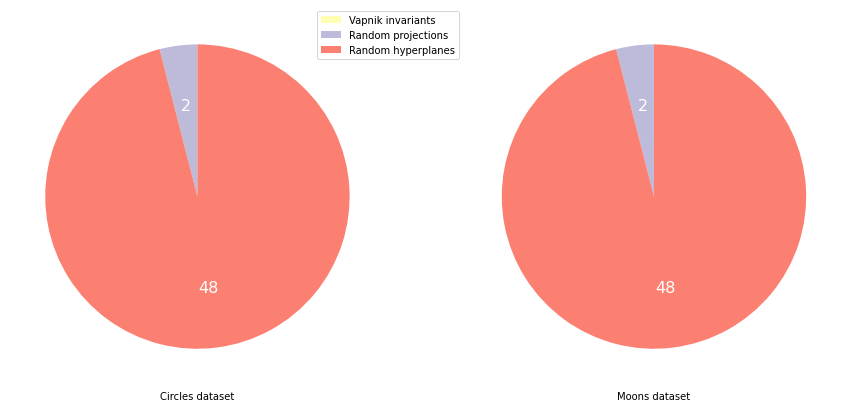

In [11]:
# Source: https://matplotlib.org/stable/gallery/lines_bars_and_markers/horizontal_barchart_distribution.html

total_selected_means = {
    'Circles': [
        np.round(np.mean(circles_n_selected[InvariantTypes.VAPNIK])),
        np.round(np.mean(circles_n_selected[InvariantTypes.PROJECTION])),
        np.round(np.mean(circles_n_selected[InvariantTypes.HYPERPLANE])),
    ],
    'Moons': [
        np.round(np.mean(moons_n_selected[InvariantTypes.VAPNIK])),
        np.round(np.mean(moons_n_selected[InvariantTypes.PROJECTION])),
        np.round(np.mean(moons_n_selected[InvariantTypes.HYPERPLANE])),
    ], 
}


category_colors = ['#ffffb3', '#bebada', '#fb8072',]
category_names = ["Vapnik invariants", "Random projections", "Random hyperplanes"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

autopct_func = lambda p: f'{p * 50 / 100:.0f}' if p > 0 else ''

_, _, txt_1 = ax1.pie(total_selected_means['Circles'], colors=category_colors, autopct=autopct_func, startangle=90)
_, _, txt_2 = ax2.pie(total_selected_means['Moons'], colors=category_colors, autopct=autopct_func, startangle=90)

for text in txt_1:
    text.set_color('white')
    text.set_size(16)

for text in txt_2:
    text.set_color('white')
    text.set_size(16)

ax1.set_xlabel('Circles dataset')
ax2.set_xlabel('Moons dataset')

plt.legend(labels=category_names, loc="upper left", bbox_to_anchor=(-0.4, 1))

plt.savefig("mean_num_selected.png")
plt.show()